In [1]:
import argparse
import logging
import math
import os
import random
import shutil
import yaml
import shutil
import json
import numpy as np
import PIL
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
import transformers
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import ProjectConfiguration, set_seed

from packaging import version
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import AutoTokenizer, PretrainedConfig

import sys
sys.path.append("./diffusers")

import diffusers
from diffusers import AutoencoderKL, DDPMScheduler, UNet2DConditionModel, DDIMScheduler
from diffusers.optimization import get_scheduler
from diffusers.utils import check_min_version, is_wandb_available
from diffusers.utils.import_utils import is_xformers_available

import pickle

from projector import Projector

torch.autograd.set_detect_anomaly(True)

/workspace/oa_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/workspace/OneActor/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/workspace/OneActor/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
# get environment configs
with open("PATH.json","r") as f:
    ENV_CONFIGS = json.load(f)

In [3]:
import yaml

with open("./config/gen_tune_inference.yaml", "r") as f:
    config = yaml.safe_load(f)
device = config['device']

In [4]:
accelerator_project_config = ProjectConfiguration(project_dir=config['output_dir']+'/'+config['dir_name'], logging_dir='logs')
accelerator = Accelerator(
    gradient_accumulation_steps=1,
    mixed_precision='no',
    log_with="tensorboard",
    project_config=accelerator_project_config,
)

/workspace/oa_venv/lib/python3.10/site-packages/accelerate/accelerator.py:401: UserWarning: `log_with=tensorboard` was passed but no supported trackers are currently installed.
  warnings.warn(f"`log_with={log_with}` was passed but no supported trackers are currently installed.")


In [5]:
# Make one log on every process with the configuration for debugging.
if accelerator.is_local_main_process:
    transformers.utils.logging.set_verbosity_warning()
    diffusers.utils.logging.set_verbosity_info()
else:
    transformers.utils.logging.set_verbosity_error()
    diffusers.utils.logging.set_verbosity_error()

# If passed along, set the training seed now.
if config['t_seed'] is not None:
    set_seed(config['t_seed'])

# Handle the repository creation
if accelerator.is_main_process:
    if config['output_dir'] is not None:
        os.makedirs(config['output_dir'], exist_ok=True)
        os.makedirs(config['output_dir']+'/'+config['dir_name'], exist_ok=True)            
        os.makedirs(config['output_dir']+'/'+config['dir_name']+'/ckpt', exist_ok=True)
        os.makedirs(config['output_dir']+'/'+config['dir_name']+'/weight', exist_ok=True)
    shutil.copyfile("./config/gen_tune_inference.yaml", config['output_dir']+'/'+config['dir_name']+'/config.yaml')

In [6]:
def import_model_class_from_model_name_or_path(
    pretrained_model_name_or_path: str, revision: str = None, subfolder: str = "text_encoder"
):
    text_encoder_config = PretrainedConfig.from_pretrained(
        pretrained_model_name_or_path, subfolder=subfolder, revision=revision
    )
    model_class = text_encoder_config.architectures[0]

    if model_class == "CLIPTextModel":
        from transformers import CLIPTextModel

        return CLIPTextModel
    elif model_class == "CLIPTextModelWithProjection":
        from transformers import CLIPTextModelWithProjection

        return CLIPTextModelWithProjection
    else:
        raise ValueError(f"{model_class} is not supported.")

In [7]:
# Load Models
pretrained_model_name_or_path = ENV_CONFIGS['paths']['sdxl_path']
# Load the tokenizers
tokenizer_one = AutoTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
    revision=None,
    use_fast=False,
)
tokenizer_two = AutoTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer_2",
    revision=None,
    use_fast=False,
)

# import correct text encoder classes
text_encoder_cls_one = import_model_class_from_model_name_or_path(
    pretrained_model_name_or_path, None
)
text_encoder_cls_two = import_model_class_from_model_name_or_path(
    pretrained_model_name_or_path, None, subfolder="text_encoder_2"
)

/workspace/oa_venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.


In [8]:
# Load scheduler and models
noise_scheduler = DDPMScheduler.from_pretrained(pretrained_model_name_or_path, subfolder="scheduler")
# Check for terminal SNR in combination with SNR Gamma
text_encoder_one = text_encoder_cls_one.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder",
)
text_encoder_two = text_encoder_cls_two.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder_2",
)

vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="vae",
)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet",
)

/workspace/OneActor/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
{'dynamic_thresholding_ratio', 'variance_type', 'thresholding', 'clip_sample_range', 'rescale_betas_zero_snr'} was not found in config. Values will be initialized to default values.
{'reverse_transformer_layers_per_block', 'dropout', 'attention_type'} was not found in config. Values will be initialized to default values.


In [9]:
vae.requires_grad_(False)
text_encoder_one.requires_grad_(False)
text_encoder_two.requires_grad_(False)
unet.requires_grad_(False)

# Build projector
projector = Projector(1280, 2048)
# Fire projector
projector.requires_grad_(True)


Projector(
  (net): Sequential(
    (0): Sequential(
      (0): Conv2d(1280, 640, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): BatchNorm2d(640, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Residual(
        (conv1): Conv2d(640, 640, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(640, 640, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(640, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm2d(640, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): Residual(
        (conv1): Conv2d(640, 640, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(640, 640, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(640, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): Ba

In [10]:
if config['use_xformers']:
    if is_xformers_available():
        import xformers

        xformers_version = version.parse(xformers.__version__)
        if xformers_version == version.parse("0.0.16"):
            logger.warn(
                "xFormers 0.0.16 cannot be used for training in some GPUs. If you observe problems during training, please update xFormers to at least 0.0.17. See https://huggingface.co/docs/diffusers/main/en/optimization/xformers for more details."
            )
        unet.enable_xformers_memory_efficient_attention()
    else:
        raise ValueError("xformers is not available. Make sure it is installed correctly")

In [11]:
unet.enable_xformers_memory_efficient_attention()

In [12]:
PIL_INTERPOLATION = {
    "linear": PIL.Image.Resampling.BILINEAR,
    "bilinear": PIL.Image.Resampling.BILINEAR,
    "bicubic": PIL.Image.Resampling.BICUBIC,
    "lanczos": PIL.Image.Resampling.LANCZOS,
    "nearest": PIL.Image.Resampling.NEAREST,
}

In [13]:
human_templates = [
    "a photo of a {}",
    "a portrait of a {}",
    "a cropped photo of the {}",
    "the photo of a {}",
    "a photo of a beautiful {}",
    "a realistic photo of a {}",
    "a dark photo of the {}",
    "a character photo of a {}",
    "a photo of the cool {}",
    "a close-up photo of a {}",
    "a face photo of the {}",
    "a cropped face of a {}",
    "a photo of the {}",
    "a good photo of the {}",
    "a high-quality photo of one {}",
    "a close-up photo of the {}",
    "a rendition of the {}",
    "a photo of the clean {}",
    "a rendition of a {}",
    "a photo of a nice {}",
    "a good photo of a {}",
    "an image of a {}",
    "a snapshot of a {}",
    "a person's photo of a {}",
    "an individual's photo of a {}",
]

In [14]:
if config['allow_tf32']:
    torch.backends.cuda.matmul.allow_tf32 = True

# Initialize the optimizer
optimizer = torch.optim.AdamW(
    projector.parameters(),  # only optimize the embeddings
    lr=config['lr'],
    betas=(0.9, 0.999),
    weight_decay=1e-2,
    eps=1e-8,
)

In [15]:
class OneActorDataset(Dataset):
    def __init__(
        self,
        config,
        repeats=100,
        interpolation="bicubic",
        flip_p=0.5,
        set="train",
    ):
        self.data_root = config['data_root'] + "/" + config['dir_name']
        self.learnable_property = config['concept_type']
        self.size = config['size']
        self.base_condition = config['base_condition']
        self.flip_p = flip_p
        self.neg_num = config['neg_num']

        for _, _, files in os.walk(self.data_root):
            break

        self.uuid = [f for f in files if 'source' in f and 'jpg' in f][0][-12:-4]

        self.image_paths = [os.path.join(self.data_root, file_path) for file_path in os.listdir(self.data_root) if os.path.splitext(file_path)[1] == '.jpg']
        self.mask_image_paths = [f[:-4] + "_mask.png" for f in self.image_paths]
        self.base_root = self.data_root + '/base'
        self.base_paths = [os.path.join(self.base_root, file_path) for file_path in os.listdir(self.base_root) if os.path.splitext(file_path)[1] == '.jpg']
        self.mask_base_paths = [f[:-4] + "_mask.png" for f in self.base_paths]

        self.num_images = len(self.image_paths)
        self.num_base = len(self.base_paths)
        self._length = self.num_images * 2

        if set == "train":
            self._length = self.num_images * repeats * 2

        self.interpolation = {
            "linear": PIL_INTERPOLATION["linear"],
            "bilinear": PIL_INTERPOLATION["bilinear"],
            "bicubic": PIL_INTERPOLATION["bicubic"],
            "lanczos": PIL_INTERPOLATION["lanczos"],
        }[interpolation]
        if self.learnable_property == 'character':
            self.templates = human_templates
        elif self.learnable_property == 'object':
            self.templates = imagenet_templates_small
        elif self.learnable_property == 'style':
            self.templates = imagenet_style_templates_small
        self.flip_transform = transforms.RandomHorizontalFlip(p=self.flip_p)    # randomly flip images

        with open(self.data_root+f'/xt_list_{self.uuid}.pkl', 'rb') as f:
            xt_dic = pickle.load(f)

        self.h_mid = xt_dic['h_mid']
        self.prompt_embed = xt_dic['prompt_embed']

        with open(self.base_root+f'/mid_list_{self.uuid}.pkl', 'rb') as f:
            self.base_mid = pickle.load(f)


    def __len__(self):
        return self._length

    def __getitem__(self, i):
        example = {}

        img_paths = []
        msk_paths = []
        h_mid_list = []
        # target samples
        target_img_path, mask_target_img_path = random.choice(list(
            zip(self.image_paths, self.mask_image_paths))
        )
        img_paths.append(target_img_path)
        msk_paths.append(mask_target_img_path)
        h_mid_list.append(self.h_mid[-1])
        # base samples
        for i in range(self.neg_num):
            ind = random.randint(0, len(self.base_paths)-1)
            img_paths.append(self.base_paths[ind])
            msk_paths.append(self.mask_base_paths[ind])
            h_mid_list.append(self.base_mid[ind])
        h_mid_list.append(random.choice(h_mid_list))
        
        img_tensors = []
        mask_tensor = []
        text_list = []
        for img_path, mask_path in zip(img_paths, msk_paths):

            image = Image.open(img_path)

            if not image.mode == "RGB":
                image = image.convert("RGB")
            # default to score-sde preprocessing
            image = np.array(image).astype(np.uint8)
            image = Image.fromarray(image)
            image = image.resize((self.size, self.size), resample=self.interpolation)
            image_f = self.flip_transform(image)
            flip_ind = image_f != image
            image = image_f
            image = np.array(image).astype(np.uint8)
            image = (image / 127.5 - 1.0).astype(np.float32)

            img_tensors.append(torch.from_numpy(image).permute(2, 0, 1))

            mask = Image.open(mask_path)
            if not mask.mode == "RGB":
                mask = mask.convert("RGB")
            mask = np.array(mask).astype(np.uint8)
            if flip_ind:
                mask = mask[:,::-1]
            # default to score-sde preprocessing

            mask = Image.fromarray(mask)
            mask = mask.resize((self.size, self.size), resample=self.interpolation)
            mask = np.array(mask).astype(np.uint8)
            mask = (mask / 127.5 - 1.0).astype(np.float32)
 
            mask_tensor.append(torch.from_numpy(mask).permute(2, 0, 1))

            text = random.choice(self.templates).format(self.base_condition)
            text_list.append(text)
        img_tensors.append(img_tensors[0])
        mask_tensor.append(mask_tensor[0])
        text_list.append(text_list[0])

        example["pixel_values"] = torch.stack(img_tensors)
        example["mask_pixel_values"] = torch.stack(mask_tensor)
        example['text'] = text_list
        example['base'] = self.base_condition
        example['h_mid'] = torch.stack(h_mid_list)
    
        return example


In [16]:
# Dataset and DataLoaders creation:
train_dataset = OneActorDataset(
    config=config,
    set='train',
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=0
)

In [17]:
a = train_dataset[40]

2


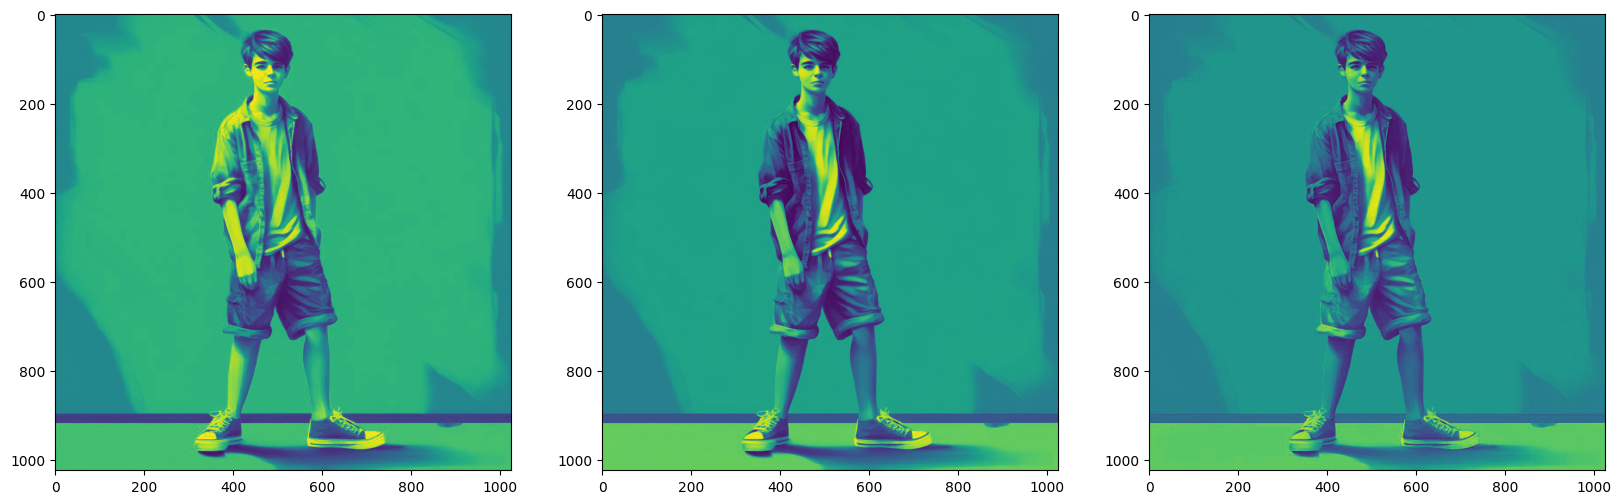

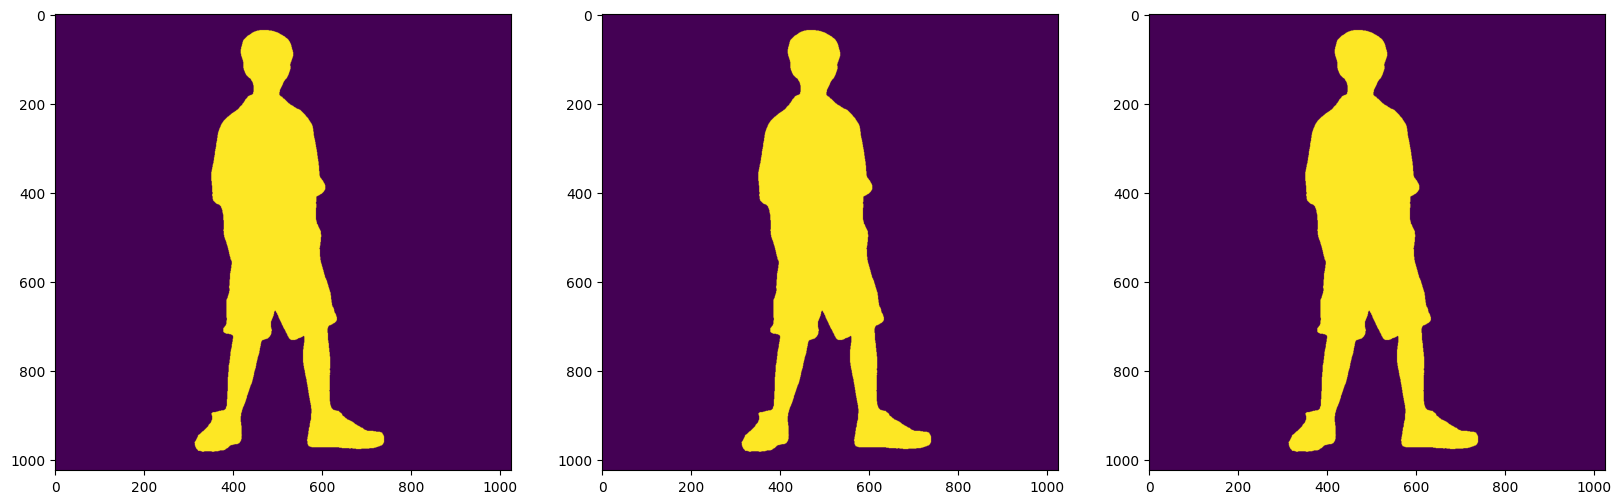

In [18]:
from PIL import Image
import matplotlib.pyplot as plt

ds = train_dataset[0]

img_num = random.randint(0, len(ds)-1)
print(img_num)
f, axarr = plt.subplots(1, 3, figsize=(20, 10))
for n in range(3):
    axarr[n].imshow(ds['pixel_values'][img_num][n])
plt.show()

f, axarr = plt.subplots(1, 3, figsize=(20, 10))
for n in range(3):
    axarr[n].imshow(ds['mask_pixel_values'][img_num][n])
plt.show()

In [19]:
overrode_max_train_steps = False
num_update_steps_per_epoch = math.ceil(len(train_dataloader))

max_train_steps = config['epochs'] * num_update_steps_per_epoch
overrode_max_train_steps = True

lr_scheduler = get_scheduler(
    "constant",
    optimizer=optimizer,
    num_warmup_steps=500 * accelerator.num_processes,
    num_training_steps=max_train_steps * accelerator.num_processes,
    num_cycles=1,
)

projector.train()
# Prepare everything with our `accelerator`.
projector, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
    projector, optimizer, train_dataloader, lr_scheduler
)

# For mixed precision training we cast all non-trainable weigths (vae, non-lora text_encoder and non-lora unet) to half-precision
# as these weights are only used for inference, keeping weights in full precision is not required.
weight_dtype = torch.float32
if accelerator.mixed_precision == "fp16":
    weight_dtype = torch.float16
elif accelerator.mixed_precision == "bf16":
    weight_dtype = torch.bfloat16
# Move vae and unet to device and cast to weight_dtype


unet.to(accelerator.device, dtype=weight_dtype)
vae.to(accelerator.device, dtype=weight_dtype)
text_encoder_one.to(accelerator.device, dtype=weight_dtype)
text_encoder_two.to(accelerator.device, dtype=weight_dtype)

# We need to recalculate our total training steps as the size of the training dataloader may have changed.
num_update_steps_per_epoch = math.ceil(len(train_dataloader))
if overrode_max_train_steps:
    max_train_steps = config['epochs'] * num_update_steps_per_epoch
# Afterwards we recalculate our number of training epochs
config['epochs'] = math.ceil(max_train_steps / num_update_steps_per_epoch)

# We need to initialize the trackers we use, and also store our configuration.
# The trackers initializes automatically on the main process.
if accelerator.is_main_process:
    accelerator.init_trackers("OneActor", config=config)

# Train!
total_batch_size = config['batch_size'] * accelerator.num_processes


In [20]:
global_step = 0
first_epoch = 0
# Potentially load in the weights and states from a previous save
if config['resume_from_checkpoint'] is not None:
    # Get the most recent checkpoint
    dirs = os.listdir(config['output_dir']+'/'+config['dir_name']+'/ckpt')
    dirs = [d for d in dirs if d.startswith("checkpoint")]
    dirs = sorted(dirs, key=lambda x: int(x.split("-")[1]))
    path = dirs[-1] if len(dirs) > 0 else None

    if path is None:
        accelerator.print(
            f"Checkpoint does not exist. Starting a new training run."
        )
        initial_global_step = 0
    else:
        accelerator.print(f"Resuming from checkpoint {path}")
        accelerator.load_state(os.path.join(config['output_dir']+'/'+config['dir_name'], 'ckpt', path))
        global_step = int(path.split("-")[1])

        initial_global_step = global_step
        first_epoch = global_step // num_update_steps_per_epoch

else:
    initial_global_step = 0

progress_bar = tqdm(
    range(0, max_train_steps),
    initial=initial_global_step,
    desc="Steps",
    # Only show the progress bar once on each machine.
    disable=not accelerator.is_local_main_process,
)

Checkpoint does not exist. Starting a new training run.


Steps:   0%|          | 0/200 [00:00<?, ?it/s]

In [39]:
best_loss = 1000.0
for epoch in range(first_epoch, config['epochs']):
    projector.train()
    train_loss = 0.0
    for step, batch in enumerate(train_dataloader):
        with accelerator.accumulate(projector):
            # import pdb; pdb.set_trace()
            # Convert images to latent space
            latents = vae.encode(batch["pixel_values"][0].to(dtype=weight_dtype)).latent_dist.sample().detach()
            mask_latents = vae.encode(batch["mask_pixel_values"][0].to(dtype=weight_dtype)).latent_dist.sample().detach()
            latents = latents * vae.config.scaling_factor
            mask_latents = mask_latents * vae.config.scaling_factor
            # Sample noise that we'll add to the latents
            noise = torch.randn_like(latents)
            noise[-1] = noise[0]    # aver is the same as target
            bsz = latents.shape[0]
            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
            timesteps = timesteps.long()

            # Add noise to the latents according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)
            noisy_mask_latents = noise_scheduler.add_noise(mask_latents, noise, timesteps)

            # time ids
            def compute_time_ids(original_size, crops_coords_top_left):
                # Adapted from pipeline.StableDiffusionXLPipeline._get_add_time_ids
                target_size = (1024, 1024)
                add_time_ids = list(original_size + crops_coords_top_left + target_size)
                add_time_ids = torch.tensor([add_time_ids])
                add_time_ids = add_time_ids.to(accelerator.device, dtype=weight_dtype)
                return add_time_ids # tensor(1, 6)
            
            original_size = (1024, 1024)
            crops_coords_top_left = (0, 0)
            add_time_ids = compute_time_ids(original_size, crops_coords_top_left).repeat(bsz, 1).to(accelerator.device)
            unet_added_conditions = {"time_ids": add_time_ids}

            text_encoders = [text_encoder_one, text_encoder_two]
            tokenizers = [tokenizer_one, tokenizer_two]
            # Get the text embedding for conditioning
            prompt_embeds_batch_list = []
            add_text_embeds_batch_list = []
            delta_emb = projector(batch['h_mid'][0, :, -1].to(device)) # torch.size(bs, 1280, 32, 32) -> torch.size(bs, 2048)
            delta_emb_aver = delta_emb[1:-1].mean(dim=0, keepdim=True)
            for b_s in range(bsz): # 1*target+n*base+1*aver
                prompt = batch['text'][b_s][0] # str
                prompt_embeds_list = []

                first = 1
                for tokenizer, text_encoder in zip(tokenizers, text_encoders):

                    text_inputs = tokenizer(
                        prompt,
                        padding="max_length",
                        max_length=tokenizer.model_max_length,
                        truncation=True,
                        return_tensors="pt",
                    )
                    tokens = tokenizer.encode(prompt)
                    
                    if first:
                        for i, token in enumerate(tokens):
                            if tokenizer.decode(token) == batch['base'][0]:
                                base_token_id = i
                                first = 0
                                break
                    text_input_ids = text_inputs.input_ids
                    prompt_embeds = text_encoder(text_input_ids.to(device), output_hidden_states=True)
                    pooled_prompt_embeds = prompt_embeds[0]
                    prompt_embeds = prompt_embeds.hidden_states[-2]
                    prompt_embeds_list.append(prompt_embeds)
                prompt_embeds = torch.concat(prompt_embeds_list, dim=-1)    # tensor(1, 77, 2048)

                if b_s == bsz-1:
                    delta_emb_ = delta_emb_aver
                else:
                    delta_emb_ = delta_emb[b_s:b_s+1]
                prompt_embeds[:, base_token_id, :] = prompt_embeds[:, base_token_id, :] + delta_emb_

                prompt_embeds_batch_list.append(prompt_embeds)
                add_text_embeds_batch_list.append(pooled_prompt_embeds)
            
            prompt_embeds = torch.concat(prompt_embeds_batch_list, dim=0)
            add_text_embeds = torch.concat(add_text_embeds_batch_list, dim=0).to(accelerator.device)

            unet_added_conditions.update({"text_embeds": add_text_embeds})
            prompt_embeds = prompt_embeds.to(accelerator.device)


            # Predict the noise residual
            model_pred = unet(noisy_latents, timesteps, encoder_hidden_states=prompt_embeds, added_cond_kwargs=unet_added_conditions).sample


            # Get the target for loss depending on the prediction type
            if noise_scheduler.config.prediction_type == "epsilon":
                target = noise
            elif noise_scheduler.config.prediction_type == "v_prediction":
                target = noise_scheduler.get_velocity(latents, noise, timesteps)
            else:
                raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")
            
            
            loss_target = F.mse_loss(model_pred[:1].float() * noisy_mask_latents[:1].float(),
                                     target[:1].float() * noisy_mask_latents[:1].float(), reduction="mean")
            loss_base = F.mse_loss(model_pred[1:-1].float() * noisy_mask_latents[1:-1].float(),
                                     target[1:-1].float() * noisy_mask_latents[1:-1].float(), reduction="mean")
            loss_aver = F.mse_loss(model_pred[-1:].float() * noisy_mask_latents[-1:].float(),
                                     target[-1:].float() * noisy_mask_latents[-1:].float(), reduction="mean")
            loss = loss_target + config['lambda1'] * loss_base + config['lambda2'] * loss_aver
            avg_loss = accelerator.gather(loss.repeat(config['batch_size'])).mean()
            train_loss += avg_loss.item()

            accelerator.backward(loss)

            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
        break

batch['pixel_values'][0].size() = torch.Size([5, 3, 1024, 1024])
tensor([313, 338, 843, 429, 164], device='cuda:0')
model_pred.float().size() = torch.Size([5, 4, 128, 128])
target.float().size() = torch.Size([5, 4, 128, 128])


In [23]:
noisy_latents.size()

torch.Size([5, 4, 128, 128])

In [ ]:
vae.encode(batch["pixel_values"][0].to(dtype=weight_dtype))

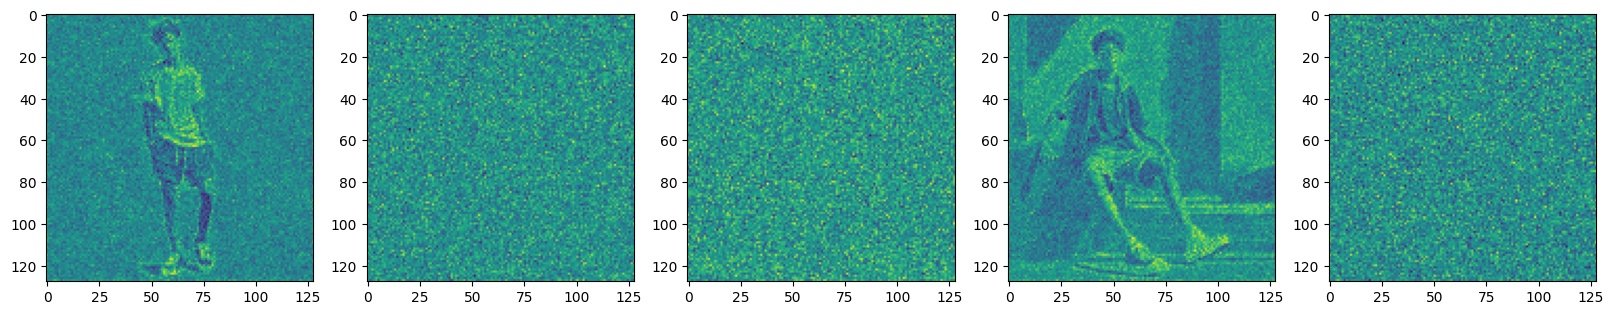

In [29]:
f, axarr = plt.subplots(1, 5, figsize=(20, 10))
for n in range(5):
    axarr[n].imshow(noisy_latents[n][0].cpu())
plt.show()

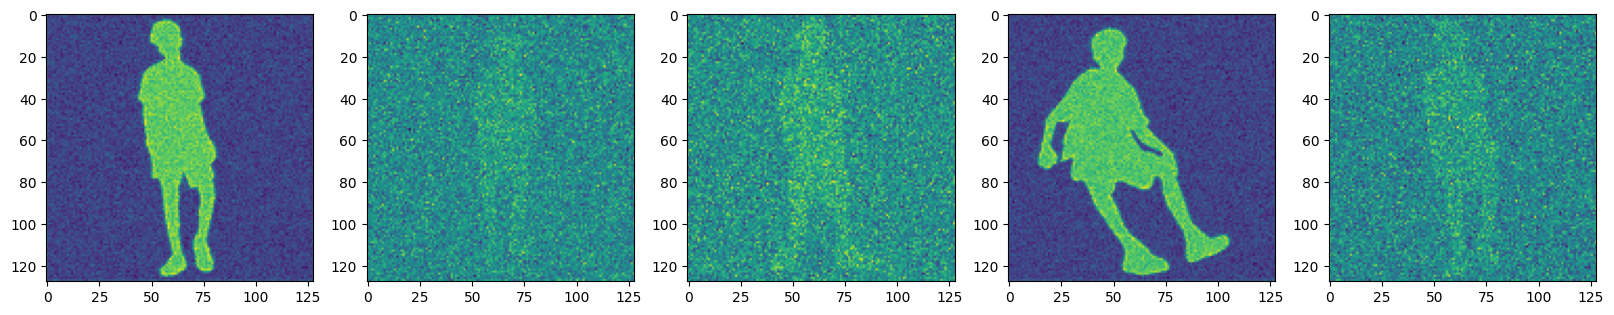

In [34]:
noisy_mask_latents_1 = noise_scheduler.add_noise(mask_latents, noise, timesteps)
f, axarr = plt.subplots(1, 5, figsize=(20, 10))
for n in range(5):
    axarr[n].imshow(noisy_mask_latents_1[n][0].cpu())
plt.show()

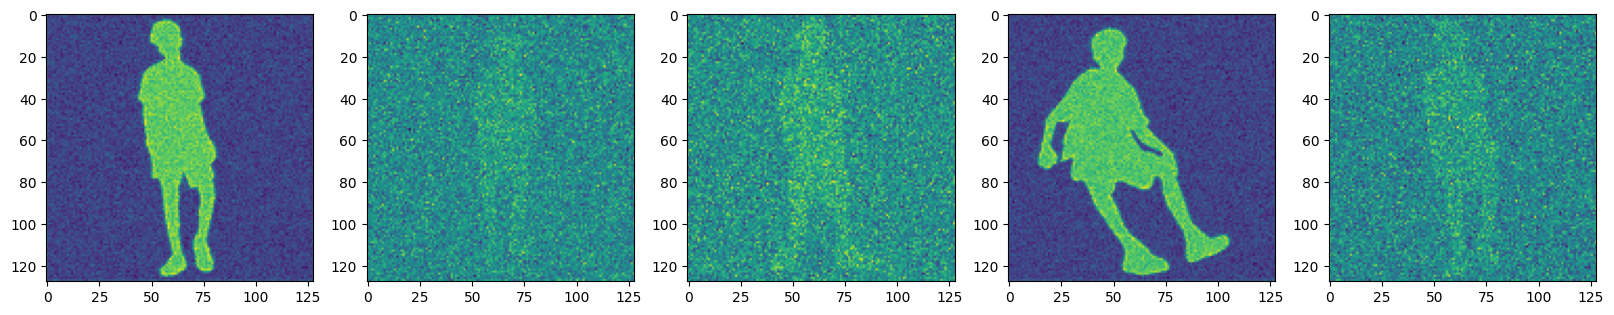

In [35]:
noisy_mask_latents_2 = noise_scheduler.add_noise(mask_latents, noise, timesteps)
f, axarr = plt.subplots(1, 5, figsize=(20, 10))
for n in range(5):
    axarr[n].imshow(noisy_mask_latents_2[n][0].cpu())
plt.show()

In [36]:
noisy_mask_latents_2[n][0].cpu() == noisy_mask_latents_1[n][0].cpu()

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])